In [8]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pickle
import normalize_data
from tqdm.notebook import tqdm
tqdm.pandas()
pd.set_option('display.max_columns', 999)
pd.set_option('display.precision', 12)

In [9]:
with open(f'{os.environ["GP_HIST_PATH"]}/../t5_data/sample4__compare_output.pkl', 'rb') as handle:
    data_dict = pickle.load(handle)
# NOTE TLE represented is probably not what you expect (but i dont have time to fix yet)
# ground truth -> X (NOT ground truth TLE)
# baseline -> X
# pred -> predicted Y

In [10]:
def compare(s1,s2):
    s = np.sqrt(((data_dict[s2][['SAT_RX','SAT_RY','SAT_RZ']] - data_dict[s1][['SAT_RX','SAT_RY','SAT_RZ']])**2).sum(axis=1))
    s.name = f'{s2}_error'
    return s


base_error = compare('tle_ground_truth','sgp4_baseline')

pred_error = compare('tle_ground_truth','model_t5_predictions')
compare_df = data_dict['sgp4_baseline'][['EPOCH_DIFF']].merge(base_error, left_index=True, right_index=True)
compare_df = compare_df.merge(pred_error, left_index=True, right_index=True)

print("baseline error")
display(base_error.describe())
print("model error")
display(pred_error.describe())
print("compare")
display(compare_df)


baseline error


count    2.069777000000e+06
mean     5.704325477708e+01
std      3.059898309820e+02
min      3.142536289600e-04
25%      1.268596850526e+00
50%      4.312537784511e+00
75%      1.771661397725e+01
max      2.375984924760e+04
Name: sgp4_baseline_error, dtype: float64

model error


count    2.069777000000e+06
mean     4.313385351485e+02
std      7.838628611859e+02
min      1.171458905918e-01
25%      1.691776959947e+02
50%      2.917713862134e+02
75%      4.640289303953e+02
max      1.552837568004e+04
Name: model_t5_predictions_error, dtype: float64

compare


,EPOCH_DIFF,sgp4_baseline_error,model_t5_predictions_error
0,1.001690209988,0.836934300296,488.788884307165
1,1.001688860012,2.147753829273,366.338886517671
2,1.001686159988,1.548379600648,393.238014114475
3,1.001686330012,3.346929693087,437.595868344800
4,2.003368019988,5.058870643815,417.419825613297
...,...,...,...
2069772,7.836440310000,465.390410916662,366.994870963376
2069773,7.309026610000,515.194004159794,224.168558904788
2069774,7.082984530000,113.195054069990,101.532024428948
2069775,6.932372470000,235.191606984830,169.975858681262


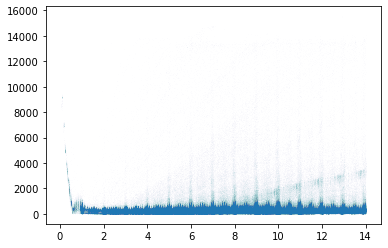

In [20]:
# top_half_model = compare_df.groupby('bin').apply(lambda x:np.mean(x.model_t5_predictions_error.nsmallest(len(x)//2)))
# plt.scatter(top_half_model.index, top_half_model)
# plt.show()
plt.scatter(compare_df.EPOCH_DIFF, compare_df.model_t5_predictions_error, s=0.001, alpha = 0.1)
plt.show()

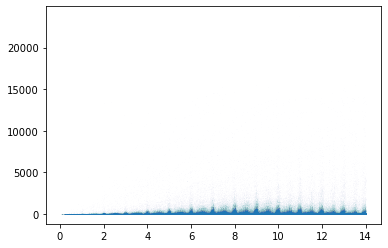

In [21]:
# top_half_baseline = compare_df.groupby('bin').apply(lambda x:np.mean(x.sgp4_baseline_error.nsmallest(len(x)//2)))
# plt.scatter(top_half_baseline.index, top_half_baseline)
# plt.show()
plt.scatter(compare_df.EPOCH_DIFF, compare_df.sgp4_baseline_error, s=0.001, alpha = 0.1)
plt.show()

In [18]:
one_day_or_less = compare_df[(compare_df.EPOCH_DIFF < 1)]
print((one_day_or_less.sgp4_baseline_error > one_day_or_less.model_t5_predictions_error).value_counts())
print(((compare_df.EPOCH_DIFF > 0.5) & (compare_df.sgp4_baseline_error > compare_df.model_t5_predictions_error)).value_counts())

False    19665
True        10
dtype: int64
False    2027362
True       42415
dtype: int64


bin
0     0.000508259212
1     0.002994230629
2     0.007998294894
3     0.013997977414
4     0.015198171610
5     0.020495024716
6     0.020693002936
7     0.022344147583
8     0.026252579587
9     0.023610957970
10    0.026701038798
11    0.024263736264
12    0.022970081842
13    0.018593616785
dtype: float64

<AxesSubplot:xlabel='bin'>

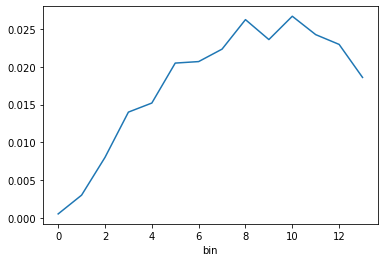

In [19]:
compare_df['bin'] = compare_df['EPOCH_DIFF'].astype(int)
compare_df['model_better'] = (compare_df.sgp4_baseline_error > compare_df.model_t5_predictions_error)
better_against_epoch_diff = compare_df.groupby('bin').apply(lambda x:np.mean(x.model_better))
display(better_against_epoch_diff)
better_against_epoch_diff.plot()